In [2]:
#!pip install torch torchvision 

In [3]:
# Imports - check to make sure all are installed 
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import pandas as pd 
import numpy as np 
from PIL import Image

In [ ]:
# Access files
# Images and labels stored in different folders
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

df = pd.read_csv("All_TIF_labeled_tiles.csv")
images = "./CNN_pngs"

df['filepath'] = df.apply(
    lambda row: os.path.join(images, str(row['File'])),
    axis=1
)

In [5]:
# CHECK - make sure it's working
# Print to see
missing = df[~df['filepath'].apply(os.path.exists)]
if len(missing) > 0:
    print(f"Warning: {len(missing)} files missing!")
    #print(missing[['File', 'filepath']].head())

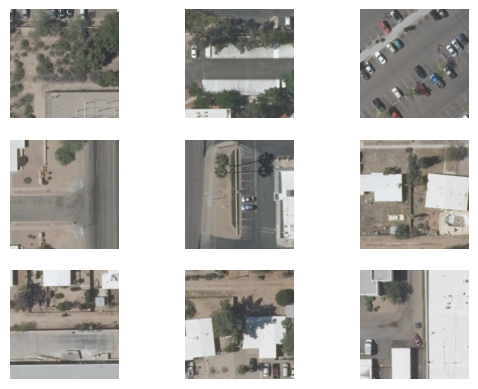

In [6]:
# Check imgs in df 
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(n=1)["filepath"].iloc[0]).convert(("RGB"))
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()

In [7]:
# Encode labels
# 1. The R/C class could be encoded several ways
# 2. For Azimuth, assign degrees or directions (think about how we will limit this later)

# Residential/Commercial class
# Option 1-binary
df['R/C'] = df['R/C'].astype(str).map({'R': 0, 'C': 1})

# Azimuth class
# Technically in degrees, but labeled N, E, S, W, NE, SE, SW, NW. Convert to int
azimuth_map = {
    'N': 0, 'NE': 1, 'E': 2, 'SE': 3,
    'S': 4, 'SW': 5, 'W': 6, 'NW': 7,
    '0': 8, 0: 8
}

df['Azimuth'] = df['Azimuth'].astype(str).map(azimuth_map)



In [8]:
print("R/C distribution:", df['R/C'].value_counts())
print("Azimuth distribution:", df['Azimuth'].value_counts())

R/C distribution: R/C
1.0    193
0.0    187
Name: count, dtype: int64
Azimuth distribution: Azimuth
8    528
4     13
6      5
5      4
2      2
Name: count, dtype: int64


In [9]:
# Split train/val/test sets
SEED = 42
train = df.sample(frac=0.7, random_state=SEED)

test = df.drop(train.index)
val = test.sample(frac=0.5)
test = test.drop(val.index)

# Will need to handle class imbalance later
print(train.shape)
print(test.shape)
print(val.shape)

(386, 8)
(83, 8)
(83, 8)


In [10]:
# Image handling:
# Need to check size, normalization, and possibly transform teh images 
sample_img = Image.open(df.iloc[0]['filepath'])
print(f"Image size: {sample_img.size}")

Image size: (256, 256)


This is the size we set for our tiling of the TIF images. If possible, let's keep this scale and see the model progress before reducing size.

In [11]:
# Use PyTorch Dataset to build custom dataset for processing
class RoofDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            row = self.dataframe.iloc[idx]
            image = Image.open(row['filepath']).convert("RGB")
            if self.transform:
                image = self.transform(image)
        
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
        
        #labels
        num_roofs  = torch.tensor(row['Num_roofs'], dtype=torch.float32)
        has_roofs  = torch.tensor(row['Has_roofs'], dtype=torch.long)
        rc_class   = torch.tensor(row['R/C'], dtype=torch.long)
        pv_class   = torch.tensor(row['PV'], dtype=torch.long)
        azimuth    = torch.tensor(row['Azimuth'], dtype=torch.long)
        if pd.isna(row['Azimuth']):
            raise ValueError(f"NaN azimuth at index {idx}")
        
        return image, {
            'num_roofs': num_roofs,
            'has_roofs': has_roofs,
            'rc_class': rc_class,
            'pv_class': pv_class,
            'azimuth': azimuth
        }


We want all labels to be predicted from the CNN, which will require a multi-class model. WHat kind of predictions are we looking for with each label?

Num_roofs: int (regression?)

Has_roofs: binary, classification

R/C: binary(?), classification

PV: binary, classification

Azimuth: int

Model goal:
regression + classification 

In [12]:
# Transform datasets 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

# If rezizing is needed, add here
# transform = transforms.Compose([
#     transforms.Resize((128, 128))

# If normalization is needed, add here
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

In [13]:
train_dataset = RoofDataset(train, transform)
test_dataset = RoofDataset(test, transform)
val_dataset = RoofDataset(val, transform)

In [14]:
# CHECK - make sure it's working
train_dataset.__getitem__(2)

(tensor([[[0.3176, 0.3373, 0.3490,  ..., 0.5412, 0.5451, 0.5490],
          [0.3098, 0.3373, 0.3412,  ..., 0.5412, 0.5412, 0.5451],
          [0.2941, 0.3294, 0.3294,  ..., 0.5373, 0.5451, 0.5451],
          ...,
          [0.2941, 0.2941, 0.2863,  ..., 0.5804, 0.5804, 0.5569],
          [0.2980, 0.2941, 0.2980,  ..., 0.5882, 0.5882, 0.5765],
          [0.2980, 0.2902, 0.3020,  ..., 0.5882, 0.6078, 0.6039]],
 
         [[0.3020, 0.3294, 0.3412,  ..., 0.5294, 0.5333, 0.5373],
          [0.2980, 0.3412, 0.3333,  ..., 0.5216, 0.5333, 0.5373],
          [0.2824, 0.3333, 0.3216,  ..., 0.5216, 0.5294, 0.5333],
          ...,
          [0.3059, 0.3059, 0.2980,  ..., 0.5686, 0.5725, 0.5451],
          [0.3098, 0.3059, 0.3020,  ..., 0.5725, 0.5725, 0.5647],
          [0.3137, 0.3020, 0.3020,  ..., 0.5765, 0.5843, 0.5922]],
 
         [[0.3020, 0.3294, 0.3412,  ..., 0.4941, 0.5020, 0.5098],
          [0.2941, 0.3255, 0.3294,  ..., 0.4941, 0.5020, 0.5098],
          [0.2824, 0.3176, 0.3176,  ...,

In [15]:
# Specify the parameters
# small and basic at first, adjust later
lr = 0.001
batch_size = 32
epochs = 20


In [16]:
# Create dataloader for the custom dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
# Build the model
class RoofCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # backbone
        self.base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_feats = self.base.fc.in_features
        self.base.fc = nn.Identity()
        
        # heads
        self.num_roofs = nn.Linear(in_feats, 1)      
        self.has_roofs = nn.Linear(in_feats, 2)      
        self.rc_class  = nn.Linear(in_feats, 3)      
        self.pv_class  = nn.Linear(in_feats, 2)      
        self.azimuth   = nn.Linear(in_feats, 9)      
    
    def forward(self, x):
        feats = self.base(x)
        
        return {
            "num_roofs": self.num_roofs(feats),
            "has_roofs": self.has_roofs(feats),
            "rc_class": self.rc_class(feats),
            "pv_class": self.pv_class(feats),
            "azimuth": self.azimuth(feats)
        }

In [19]:
# Specify the loss type
# since there are different types of outputs, we need different loss functions
model = RoofCNN().to(device)

criterion_mse = nn.MSELoss()
criterion_ce = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

14.3%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/codespace/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


NameError: name 'device' is not defined

In [ ]:
# Loss weights (tune these based on importance/results)
loss_weights = {
    'num_roofs': 1.0,
    'has_roofs': 1.0,
    'rc_class': 1.0,
    'pv_class': 1.0,
    'azimuth': 1.0
}

In [ ]:
# Collect training history for plotting later
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc_has': [], 'val_acc_has': [],
    'train_acc_rc': [], 'val_acc_rc': [],
    'train_acc_pv': [], 'val_acc_pv': [],
    'train_acc_az': [], 'val_acc_az': []
}

In [ ]:
# Build the training and testing loops
for epoch in range(epochs):
    model.train()
    total_loss_train = 0.0
    correct_has, correct_rc, correct_pv, correct_az = 0, 0, 0, 0
    total_samples = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = {k: v.to(device) for k, v in labels.items()}

        outputs = model(imgs)

        # Losses
        loss_num = criterion_mse(outputs["num_roofs"].squeeze(), labels_device["num_roofs"])
        loss_has = criterion_ce(outputs["has_roofs"], labels_device["has_roofs"])
        loss_rc = criterion_ce(outputs["rc_class"], labels_device["rc_class"])
        loss_pv = criterion_ce(outputs["pv_class"], labels_device["pv_class"])
        loss_az = criterion_ce(outputs["azimuth"], labels_device["azimuth"])
            
        loss = (loss_weights['num_roofs'] * loss_num +
                loss_weights['has_roofs'] * loss_has +
                loss_weights['rc_class'] * loss_rc +
                loss_weights['pv_class'] * loss_pv +
                loss_weights['azimuth'] * loss_az)
            
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss_train += loss.item() * imgs.size(0)
        batch_size = imgs.size(0)
        total_samples += batch_size
        
        # Calculate accuracies
        correct_has += (outputs["has_roofs"].argmax(1) == labels_device["has_roofs"]).sum().item()
        correct_rc += (outputs["rc_class"].argmax(1) == labels_device["rc_class"]).sum().item()
        correct_pv += (outputs["pv_class"].argmax(1) == labels_device["pv_class"]).sum().item()
        correct_az += (outputs["azimuth"].argmax(1) == labels_device["azimuth"]).sum().item()
    
    # Average training metrics
    avg_train_loss = total_loss_train / total_samples
    acc_has_train = 100 * correct_has / total_samples
    acc_rc_train = 100 * correct_rc / total_samples
    acc_pv_train = 100 * correct_pv / total_samples
    acc_az_train = 100 * correct_az / total_samples

    # VALIDATION
    model.eval()
    total_loss_val = 0
    correct_has_val, correct_rc_val, correct_pv_val, correct_az_val = 0, 0, 0, 0
    total_samples_val = 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels_device = {k: v.to(device) for k, v in labels.items()}
            
            # Forward pass
            outputs = model(imgs)
            
            # Calculate losses
            loss_num = criterion_mse(outputs["num_roofs"].squeeze(), labels_device["num_roofs"])
            loss_has = criterion_ce(outputs["has_roofs"], labels_device["has_roofs"])
            loss_rc = criterion_ce(outputs["rc_class"], labels_device["rc_class"])
            loss_pv = criterion_ce(outputs["pv_class"], labels_device["pv_class"])
            loss_az = criterion_ce(outputs["azimuth"], labels_device["azimuth"])
            
            loss = (loss_weights['num_roofs'] * loss_num +
                    loss_weights['has_roofs'] * loss_has +
                    loss_weights['rc_class'] * loss_rc +
                    loss_weights['pv_class'] * loss_pv +
                    loss_weights['azimuth'] * loss_az)
            
            # Track metrics
            batch_size = imgs.size(0)
            total_loss_val += loss.item() * batch_size
            total_samples_val += batch_size
            
            # Calculate accuracies
            correct_has_val += (outputs["has_roofs"].argmax(1) == labels_device["has_roofs"]).sum().item()
            correct_rc_val += (outputs["rc_class"].argmax(1) == labels_device["rc_class"]).sum().item()
            correct_pv_val += (outputs["pv_class"].argmax(1) == labels_device["pv_class"]).sum().item()
            correct_az_val += (outputs["azimuth"].argmax(1) == labels_device["azimuth"]).sum().item()
    
    # Average validation metrics
    avg_val_loss = total_loss_val / total_samples_val
    acc_has_val = 100 * correct_has_val / total_samples_val
    acc_rc_val = 100 * correct_rc_val / total_samples_val
    acc_pv_val = 100 * correct_pv_val / total_samples_val
    acc_az_val = 100 * correct_az_val / total_samples_val
    
    # Store history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc_has'].append(acc_has_train)
    history['val_acc_has'].append(acc_has_val)
    history['train_acc_rc'].append(acc_rc_train)
    history['val_acc_rc'].append(acc_rc_val)
    history['train_acc_pv'].append(acc_pv_train)
    history['val_acc_pv'].append(acc_pv_val)
    history['train_acc_az'].append(acc_az_train)
    history['val_acc_az'].append(acc_az_val)
    
    # Print epoch results
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"  Has_Roofs - Train: {acc_has_train:.2f}% | Val: {acc_has_val:.2f}%")
    print(f"  R/C Class - Train: {acc_rc_train:.2f}% | Val: {acc_rc_val:.2f}%")
    print(f"  PV Class  - Train: {acc_pv_train:.2f}% | Val: {acc_pv_val:.2f}%")
    print(f"  Azimuth   - Train: {acc_az_train:.2f}% | Val: {acc_az_val:.2f}%")
    print()

In [ ]:
# Verify results
from sklearn.metrics import f1_score
# TEST EVALUATION
model.eval()
test_metrics = {
    'loss': 0, 'correct_has': 0, 'correct_rc': 0,
    'correct_pv': 0, 'correct_az': 0, 'mse_num': 0
}

all_preds = { 'has_roofs': [], 'rc_class': [], 'pv_class': [], 'azimuth': [] }
all_labels = { 'has_roofs': [], 'rc_class': [], 'pv_class': [], 'azimuth': [] }

total_test = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels_device = {k: v.to(device) for k, v in labels.items()}
        
        outputs = model(imgs)

        batch_size = imgs.size(0)
        total_test += batch_size
        
        # Accuracies
        test_metrics['correct_has'] += (outputs["has_roofs"].argmax(1) == labels_device["has_roofs"]).sum().item()
        test_metrics['correct_rc'] += (outputs["rc_class"].argmax(1) == labels_device["rc_class"]).sum().item()
        test_metrics['correct_pv'] += (outputs["pv_class"].argmax(1) == labels_device["pv_class"]).sum().item()
        test_metrics['correct_az'] += (outputs["azimuth"].argmax(1) == labels_device["azimuth"]).sum().item()

        for key in all_preds.keys():
            all_preds[key].extend(outputs[key].argmax(1).cpu().numpy())
            all_labels[key].extend(labels_device[key].cpu().numpy())
        
        # MSE for regression
        mse = ((outputs["num_roofs"].squeeze() - labels_device["num_roofs"])**2).sum().item()
        test_metrics['mse_num'] += mse

f1_has = f1_score(all_labels['has_roofs'], all_preds['has_roofs'], average='binary')
f1_rc  = f1_score(all_labels['rc_class'],   all_preds['rc_class'],   average='macro')
f1_pv  = f1_score(all_labels['pv_class'],   all_preds['pv_class'],   average='macro')
f1_az  = f1_score(all_labels['azimuth'],    all_preds['azimuth'],    average='macro')

print("\n=== TEST RESULTS ===")
print(f"Has Roofs Accuracy: {100 * test_metrics['correct_has'] / total_test:.2f}%")
print(f"R/C Class Accuracy: {100 * test_metrics['correct_rc'] / total_test:.2f}%")
print(f"PV Class Accuracy: {100 * test_metrics['correct_pv'] / total_test:.2f}%")
print(f"Azimuth Accuracy: {100 * test_metrics['correct_az'] / total_test:.2f}%")
print(f"Num Roofs MSE: {test_metrics['mse_num'] / total_test:.4f}")

# F1 score (macro for multi-class, typical for CNNs)
print("\n--- F1 SCORES ---")
print(f"Has Roofs F1: {f1_has:.4f}")
print(f"R/C Class F1: {f1_rc:.4f}")
print(f"PV Class F1: {f1_pv:.4f}")
print(f"Azimuth F1:  {f1_az:.4f}")

In [ ]:
#Plot the results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Val')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Has Roofs Accuracy
axes[0, 1].plot(history['train_acc_has'], label='Train')
axes[0, 1].plot(history['val_acc_has'], label='Val')
axes[0, 1].set_title('Has Roofs Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# R/C Class Accuracy
axes[0, 2].plot(history['train_acc_rc'], label='Train')
axes[0, 2].plot(history['val_acc_rc'], label='Val')
axes[0, 2].set_title('R/C Classification Accuracy')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy (%)')
axes[0, 2].legend()
axes[0, 2].grid(True)

# PV Class Accuracy
axes[1, 0].plot(history['train_acc_pv'], label='Train')
axes[1, 0].plot(history['val_acc_pv'], label='Val')
axes[1, 0].set_title('PV Classification Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Azimuth Accuracy
axes[1, 1].plot(history['train_acc_az'], label='Train')
axes[1, 1].plot(history['val_acc_az'], label='Val')
axes[1, 1].set_title('Azimuth Classification Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Hide unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

1. Performance Metrics:

✔ Accuracy: The proportion of correctly classified instances out of the total instances in the test set. While intuitive, it can be misleading in cases of imbalanced datasets.
- Precision: The ratio of true positive predictions to the total positive predictions (true positives + false positives). It measures the model's ability to avoid false positives.
- Recall (Sensitivity): The ratio of true positive predictions to the total actual positive instances (true positives + false negatives). It measures the model's ability to identify all positive instances.
- F1-Score: The harmonic mean of precision and recall, providing a balanced measure that considers both false positives and false negatives. It is particularly useful for imbalanced datasets. 
- Confusion Matrix: A table that summarizes the performance of a classification model, showing the counts of true positives, true negatives, false positives, and false negatives. This provides a detailed breakdown of classification errors.
- Loss: The value of the loss function on the test set, indicating the discrepancy between the model's predictions and the true labels. A lower loss generally signifies better performance.

2. Evaluation Process:

- Prepare the Test Set: Ensure a representative and independent test dataset is available, which the model has not encountered during training or validation.
- Make Predictions: Use the trained CNN model to predict the classes for the images in the test set.
- Calculate Metrics: Compute the chosen performance metrics (accuracy, precision, recall, F1-score, etc.) based on the model's predictions and the true labels of the test set.
- Analyze the Confusion Matrix: Examine the confusion matrix to understand specific types of errors the model is making and identify classes where performance is weaker.
- Visualize Results (Optional): Visualize model parameters (e.g., filters in convolutional layers) or misclassified images to gain insights into the model's behavior and identify areas for improvement.
3. Considerations:
- Data Imbalance: If the classes in your dataset are imbalanced, metrics like precision, recall, and F1-score are more informative than accuracy alone.
- Overfitting: A significant difference between training accuracy/loss and test accuracy/loss can indicate overfitting, where the model has memorized the training data rather than learning generalizable features.
- Cross-Validation: For smaller datasets, k-fold cross-validation can provide a more robust estimate of the model's performance by training and evaluating the model multiple times on different subsets of the data.

4. Key Hyperparameters to Tune

- Learning Rate: Crucial for convergence; often start high and decrease, or use schedulers (e.g., 0.001 to 0.0001).
- Epochs: More epochs improve performance up to a point; use early stopping if validation loss rises.
- Batch Size: Affects memory and convergence; try powers of 2 (8, 16, 32, 64).
- Optimizer: Adam often faster; SGD is a classic.
- Dropout: Add layers to prevent overfitting (e.g., 0.25).
- Layers/Filters/Kernel Size: Adjust network complexity.
5. Tuning Strategies & Techniques
- Grid/Random Search: Systematically test parameter combinations.
- Transfer Learning: Use pre-trained models (ImageNet) and fine-tune (freeze early layers, train later ones).
- Data Augmentation: Increase dataset size virtually (flips, rotations, zooms).
- Class Weighting: Adjust weights for imbalanced classes.
- Start Simple: Fewer layers/epochs first, then scale up